In [1]:
import os
import math

import torch
import torch.nn.functional as F
from tqdm import tqdm

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.ddpm.denoising_diffusion_1d import Unet1D, GaussianDiffusion1D, Dataset1D, Trainer1D
from scorefield.models.ddpm.gaussian_diffusion import Diffusion
from scorefield.utils.rendering import Maze2dRenderer
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import log_num_check, imshow, gen_goals, random_batch, eval_batch
from scorefield.utils.diffusion_utils import bilinear_interpolate


/home/junwoo/anaconda3/envs/scorefield/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No module named 'flow'
No module named 'carla'
pybullet build time: May 20 2022 19:44:17


/home/junwoo/anaconda3/envs/scorefield/lib/python3.8/site-packages/gym/utils/seeding.py:38: DeprecationWarning: WARN: Function `rng.randn(*size)` is marked as deprecated and will be removed in the future. Please use `rng.standard_normal(size)` instead.
  deprecation(
/home/junwoo/scorefield/scorefield/utils/rendering.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.fromstring(img_as_string, dtype='uint8').reshape((height, width, 4))[:,:,:3]


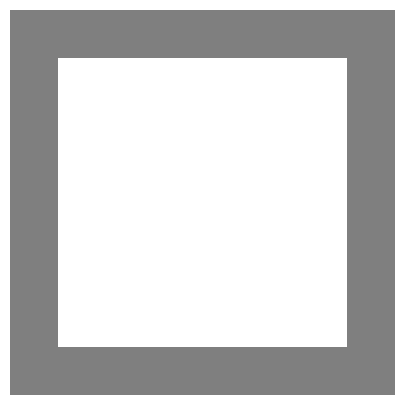

In [2]:
# Args
sac_config_dir = "/home/junwoo/scorefield/scorefield/configs/diffusion.yaml"
args = load_config(sac_config_dir)
device = args['device']

renderer = Maze2dRenderer(args)
env = renderer.env

model_path = os.path.join(args['log_path'], args['model_path'])

env.reset()
map_img = renderer.map_init()

In [3]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8)
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)
        
    def forward(self, obs, x, t):
        score_map = super().forward(obs, t)
        score = bilinear_interpolate(score_map, x)    # output: (B,2)
        return score

img_size = args['image_size']
noise_steps = args['noise_steps']
train_lr = args['train_lr']
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = Diffusion(
    input_size = (2,), 
    noise_steps= noise_steps,
    device=device,
)

optim = torch.optim.Adam(params=model.parameters(), lr=train_lr)

In [4]:
epochs = args['epochs']
batch_size = args['batch_size']

for iters in range(epochs):
    obs, goals = random_batch(renderer, map_img, batch_size)
    obs = torch.tensor(obs, dtype=torch.float32).to(device)
    goals = torch.tensor(goals).to(device)
    t = diffusion.sample_timesteps(batch_size).to(device)
    
    x_t = diffusion.noise_goal(goals, t).to(device)
    target_score = -(x_t - goals)  # It has to be divided by sigma^2, but sigma=1 in this case
    predicted_score = model(obs, x_t, t)
        
    loss = F.mse_loss(predicted_score, target_score)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if iters % 100 == 0:
        print(f"iter {iters}: {loss.item()}")
    
    

iter 0: 140.65213012695312
iter 100: 11.471358299255371
iter 200: 10.385260581970215
iter 300: 4.039562225341797
iter 400: 9.972517013549805
iter 500: 7.142106056213379
iter 600: 7.842304229736328
iter 700: 5.50502872467041
iter 800: 7.726894378662109
iter 900: 3.068937301635742
iter 1000: 8.652286529541016
iter 1100: 6.7918243408203125
iter 1200: 10.692790985107422
iter 1300: 4.7898406982421875
iter 1400: 7.0443291664123535
iter 1500: 5.160170078277588
iter 1600: 9.308061599731445
iter 1700: 4.450427532196045
iter 1800: 6.8185625076293945
iter 1900: 6.810050964355469


In [5]:
torch.save(model.state_dict(), "./logs/pretrained/denoising.pt")

In [6]:
model = model.eval()

eval_batch_size = args['eval_batch_size']
init_state = args['init_state']

obs = eval_batch(renderer, map_img, init_state, eval_batch_size, device=device)
obs = torch.tensor(obs, dtype=torch.float32).to(device)
x = torch.tensor(init_state).to(device)

dt = 0.01
trajectory = [x]

for t in tqdm(range(noise_steps)):
    with torch.no_grad():
        score = model(obs, x, noise_steps-t)
    z_t = torch.randn_like(x)   # z_t ~ N(0,I)
        
    x = x + score * dt / 2. + math.sqrt(dt) * z_t
    trajectory.append(x)
trajectory = torch.tensor(trajectory)

KeyError: 'eval_batch_size'